In [1]:
import streamlit as st
from PIL import Image
from skimage import data
from skimage import transform
from skimage.feature import (blob_log)
from matplotlib import pyplot as plt
from skyfield.api import Star, Topos, load
from skyfield.data import hipparcos
import numpy as np
import os
import time
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [2]:

def makeDistHist(star_list):
    nblob,dem = star_list.shape
    blob_dist = []
    
    for row in range(nblob):
        rdistances = np.sqrt((star_list[:,0] - star_list[row,0])**2 + (star_list[:,1] - star_list[row,1])**2)
#         rdistances /= np.max(rdistances)
        rdistances = rdistances[np.where(rdistances < 1000)]
        blob_dist.append(np.histogram(rdistances,bins=40)[0])
    return np.array(blob_dist)

stardict = {}
with open('common_stars.txt') as f:
    lines = f.readlines()
    for line in lines:
        entry = line.strip().split("\t")
        stardict[int(entry[1])] = entry[0]
        stardict[int(entry[3])] = entry[2]

df = df[df['magnitude'] <= 3.0]
print('After filtering, there are {} stars'.format(len(df)))
bright_stars = Star.from_dataframe(df)

planets = load('de421.bsp')
earth = planets['earth']
ts = load.timescale()
cos = earth + Topos('38.8605998 N', '104.6751112 W', elevation_m=2000)


def getChart(timestamp):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute,
               timestamp.second)
    apparent = cos.at(t).observe(bright_stars).apparent()
#     ra, dec, distance = apparent.radec('date')
    alt,az,distance = apparent.altaz()
    az_deg = np.pi*np.array(az.degrees) / 180
#     ax.scatter(az_deg, 90 - alt.degrees, 50*df['magnitude'], 'k')
    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 90)
    mag = np.array(10*(8-df['magnitude']))[idxs]
    x = (rad[idxs]*np.cos(az_deg[idxs])/180 + 0.5) * 4144/2
    y = (rad[idxs]*np.sin(az_deg[idxs])/180 + 0.5) * 2822/2
#     hipvals = hips[idxs]
    ret = np.zeros((len(x),3))
    ret[:,0] = x
    ret[:,1] = y
    ret[:,2] = mag
    return ret
    


After filtering, there are 177 stars


streamlit/pic000100.dat
2021-01-22 02:42:30
82
Done with distances


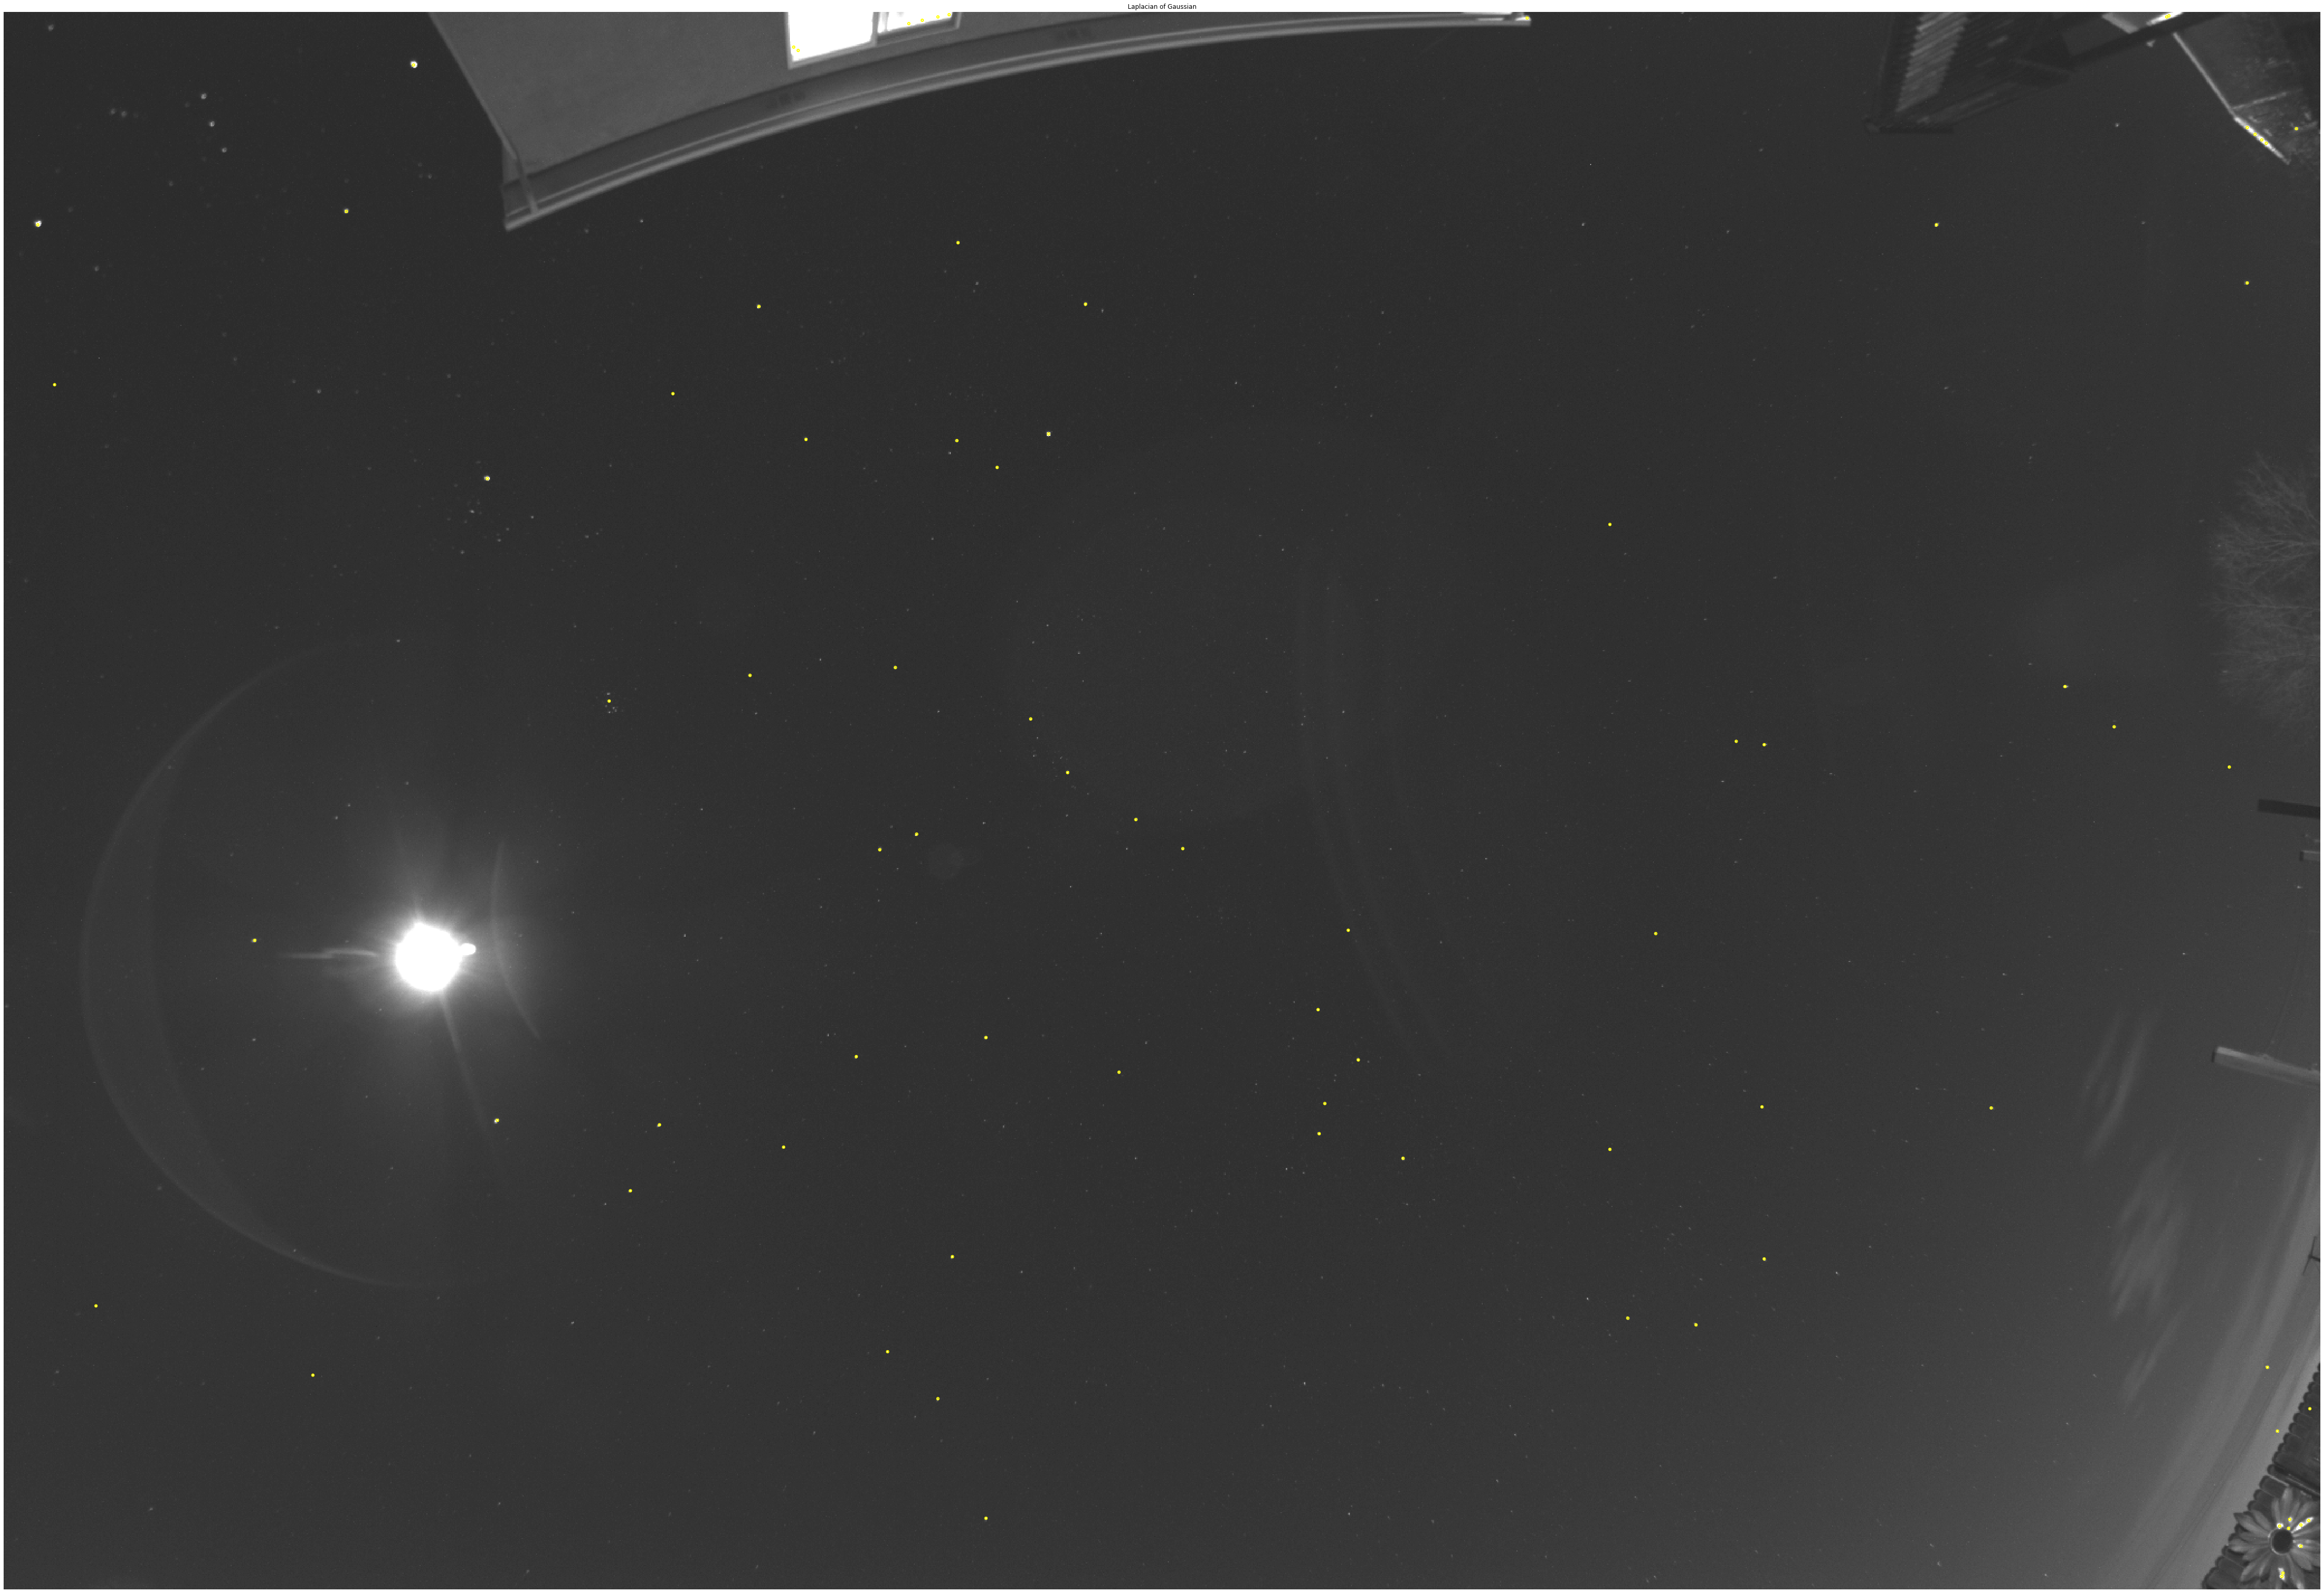

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)
# for cc in range(1):

fname = f"streamlit/pic{100:06d}.dat"
print(fname)
raw = np.fromfile(fname, dtype=np.float64).reshape((2822,4144))
#     print(raw.shape)

tstamp = os.path.getmtime(fname)
#     print(tstamp)

timestamp = datetime.fromtimestamp(tstamp)
print(timestamp)


parray = 0.2125*raw[::2,::2] + 0.7154 * (raw[1::2,::2] + raw[::2,1::2]) / 2.0 + 0.0721 * raw[1::2,1::2]
out = parray / np.max(parray)

blobs_log = blob_log(out, max_sigma=120, num_sigma=5, threshold=.005)

starblobs = blobs_log[np.where(blobs_log[:,2] == 1)]
print(starblobs.shape[0])

# starblobs[:,0] = 1411 - starblobs[:,0]

blob_dist = makeDistHist(starblobs)
print("Done with distances")

# starblobs[:,0] = 1411 - starblobs[:,0]

star_log = getChart(timestamp)
star_dist = makeDistHist(star_log)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
swgain = 20

blobs_list = [blobs_log]
colors = ['yellow']
titles = ['Laplacian of Gaussian']
sequence = zip(blobs_list, colors, titles)

# ax = axes.ravel()
# ax[1].imshow(immask, cmap='gray', interpolation='none')
# ax[1].set_title("Mask using variance")

for idx, (blobs, color, title) in enumerate(sequence):
    ax.set_title(title)
    ax.imshow(out*swgain, cmap='gray', interpolation='none',vmin=0.1, vmax=0.6)
    for blob in starblobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()
    

plt.show()

Bellatrix


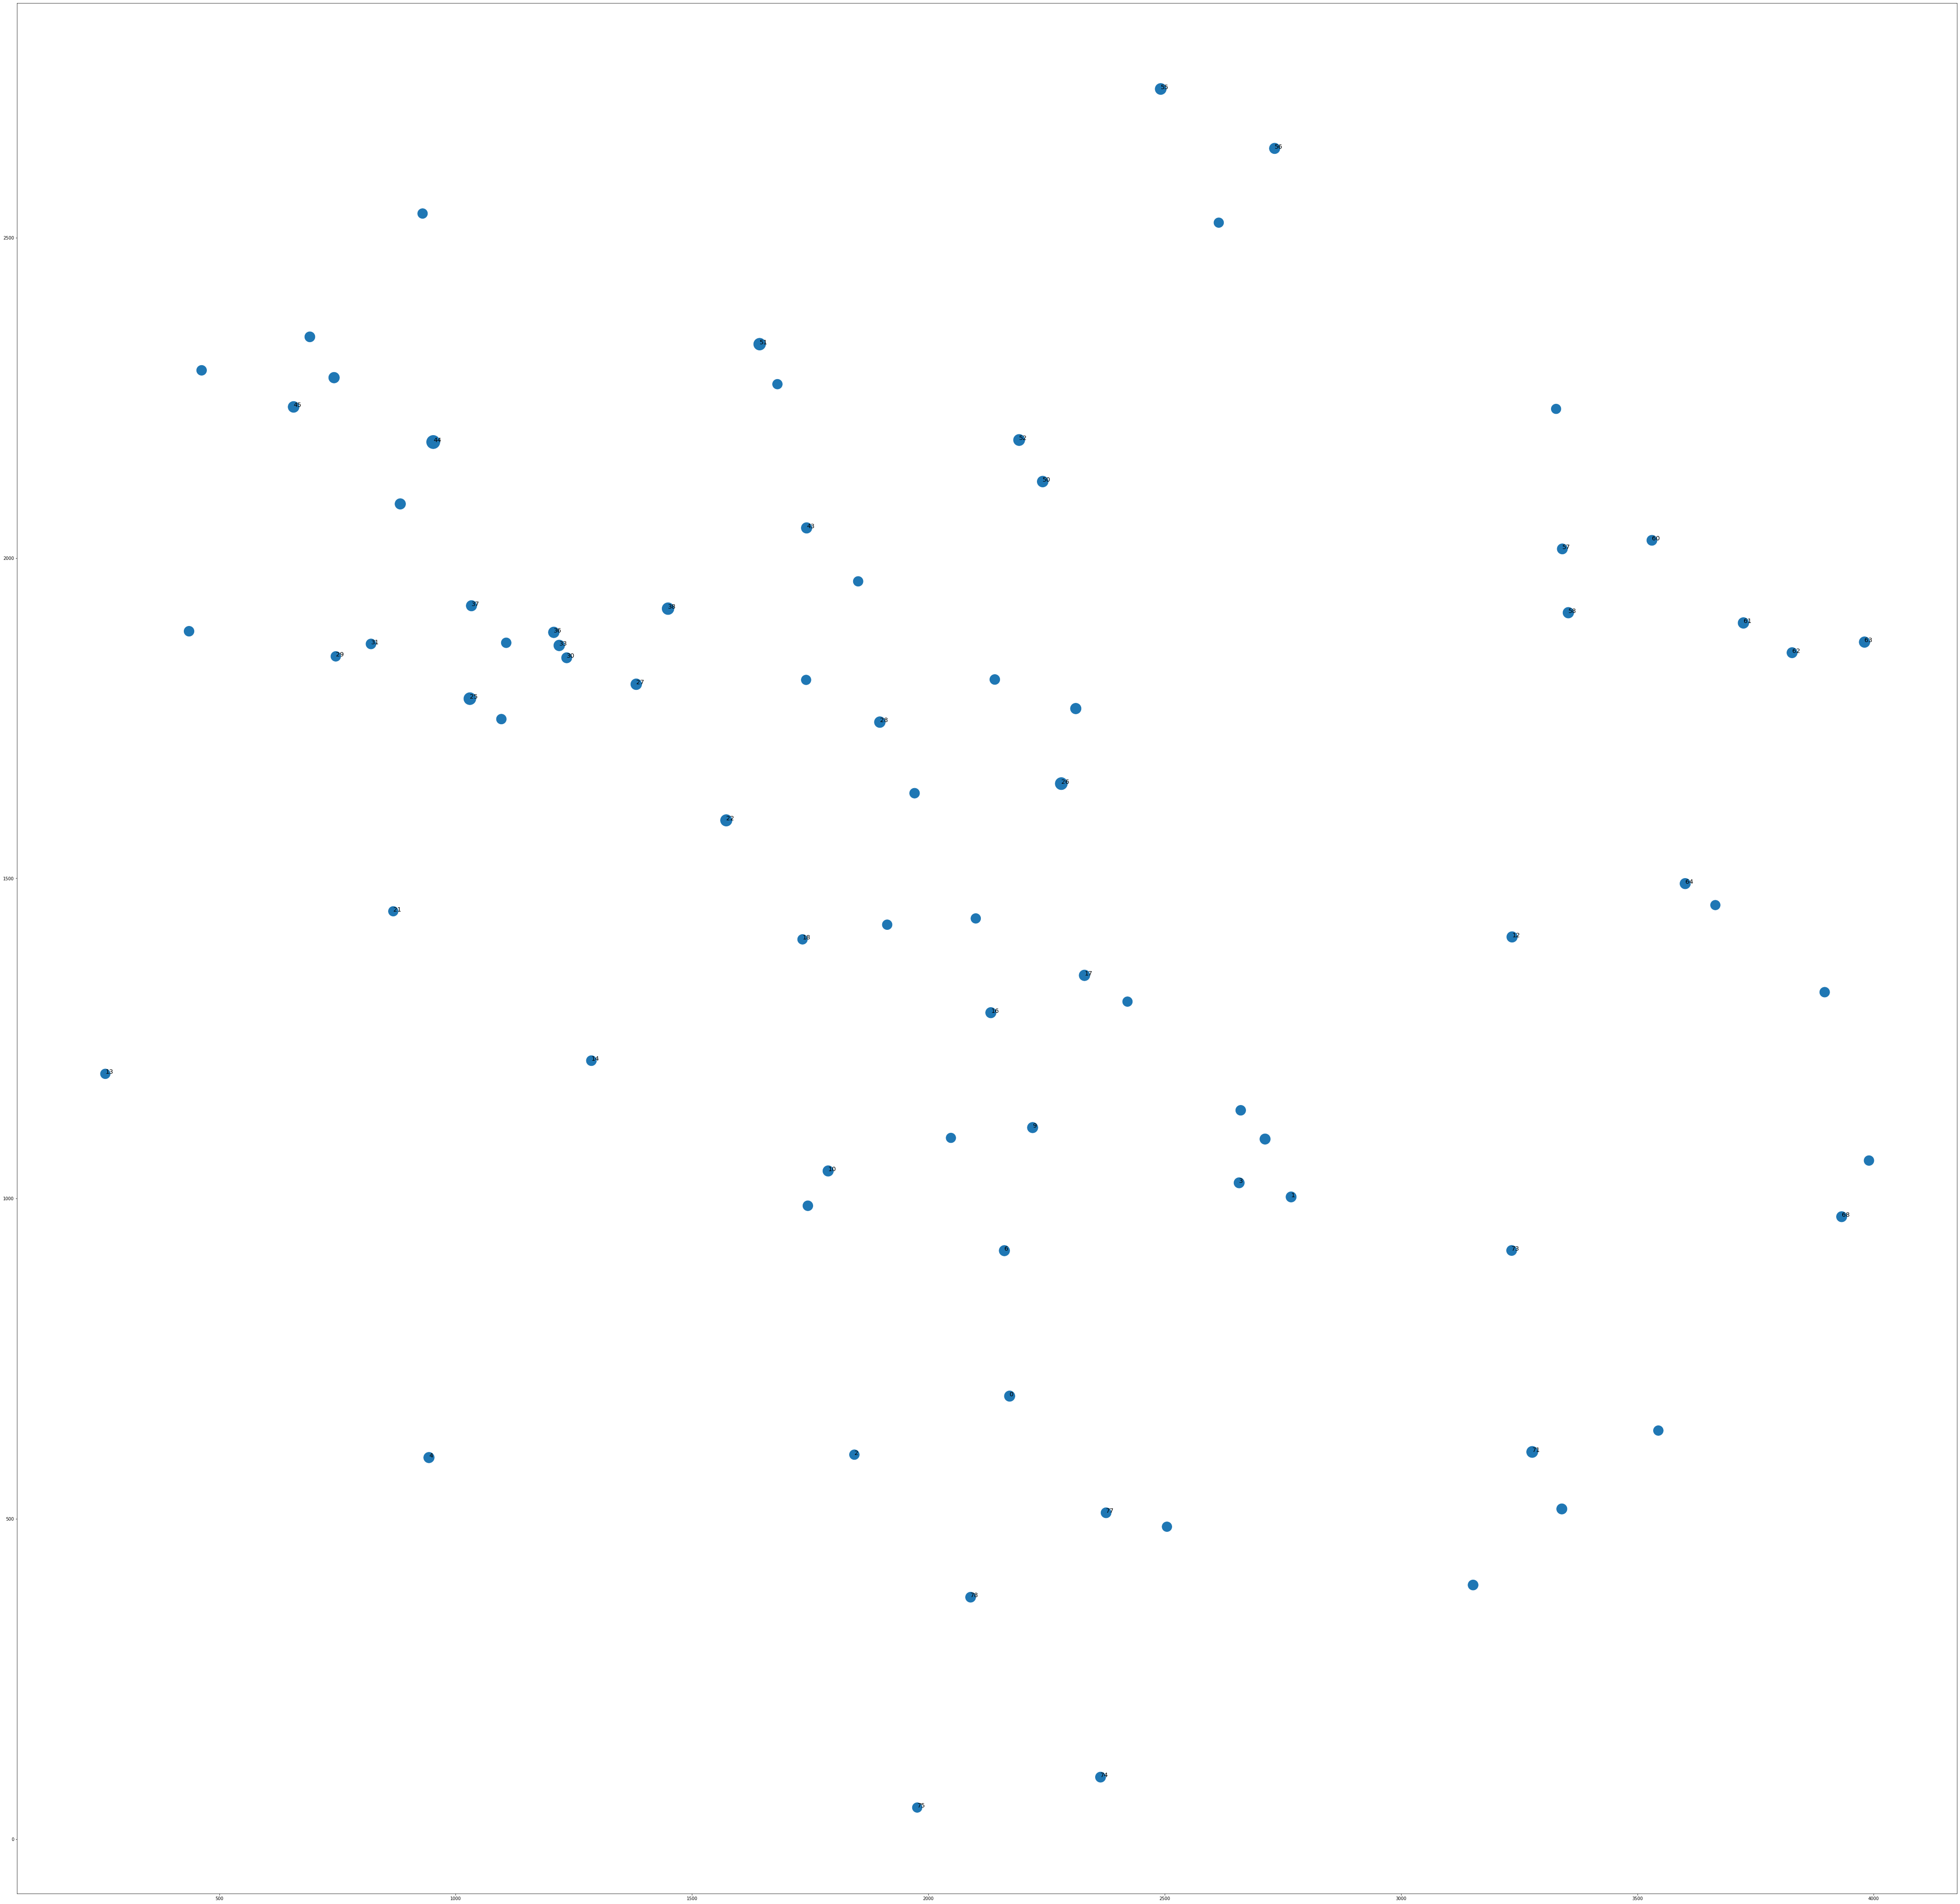

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)

for cnt in range(1):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute+cnt,
               timestamp.second)
#     print(t)
#     astrometric = boston.at(t).observe(bright_stars)
    apparent = cos.at(t).observe(bright_stars).apparent()
#     ra, dec, distance = apparent.radec('date')
    alt,az,distance = apparent.altaz()
    az_deg = np.pi*np.array(az.degrees) / 180
#     ax.scatter(az_deg, 90 - alt.degrees, 50*df['magnitude'], 'k')
    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 90)
    mag = np.array(10*(8-df['magnitude']))[idxs]
    x = (rad[idxs]*np.cos(az_deg[idxs])/180 + 0.5) * 4144
    y = (rad[idxs]*np.sin(az_deg[idxs])/180 + 0.5) * 2822
    hipvals = hips[idxs]
    ax.scatter(x, y,mag*10)
#     print(np.min(x),np.max(x),np.min(y),np.max(y))
    
    if cnt == 0:
        for idx,hip in enumerate(hipvals):
            if hip in stardict:
                if idx == 27:
                    print(stardict[hip])
#                 ax.annotate(stardict[hip], (x[idx], y[idx]))
                ax.annotate(f"{idx}", (x[idx], y[idx]),fontsize='x-large')

plt.show()

82
(82, 40)
75
75
[178. 306.   1.]
[988.21763694  24.61211403  50.5       ]


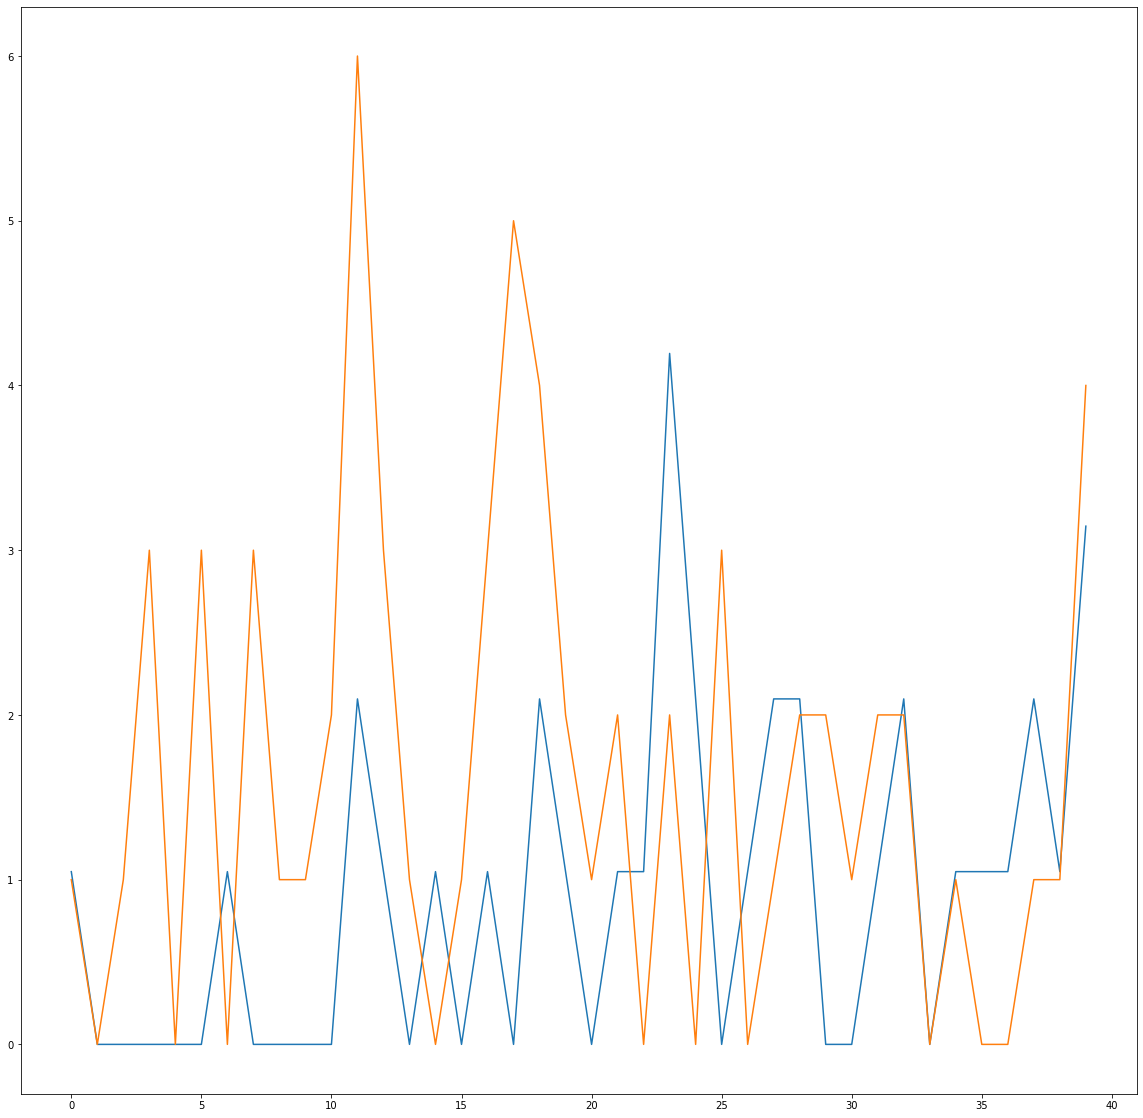

In [5]:
# blob_dist
# star_dist
fig, ax = plt.subplots(1, 1, figsize=(20, 20), sharex=True, sharey=True)
star0 = blob_dist#[np.where(blob_dist[:,0] < 20)]
print(len(star0))
testidx = 50

star0 = star0[testidx] / np.std(star0[testidx])

print(blob_dist.shape)

# print(star0)

ax.plot(np.arange(len(star0)), star0)
lms = np.zeros(len(star_dist))
for cnt,vv in enumerate(star_dist):
    val = vv / np.std(vv)
    lms[cnt] = np.sqrt(np.sum((star0-val)**2))

foundidx = np.argmin(lms)
print(foundidx)
foundidx = 27

minstar = star_dist[foundidx]
# minstar = star_dist[36]
ax.plot(np.arange(len(star0)), minstar)
print(np.argmin(lms))
print(starblobs[testidx])
print(star_log[np.argmin(lms)])
plt.show()

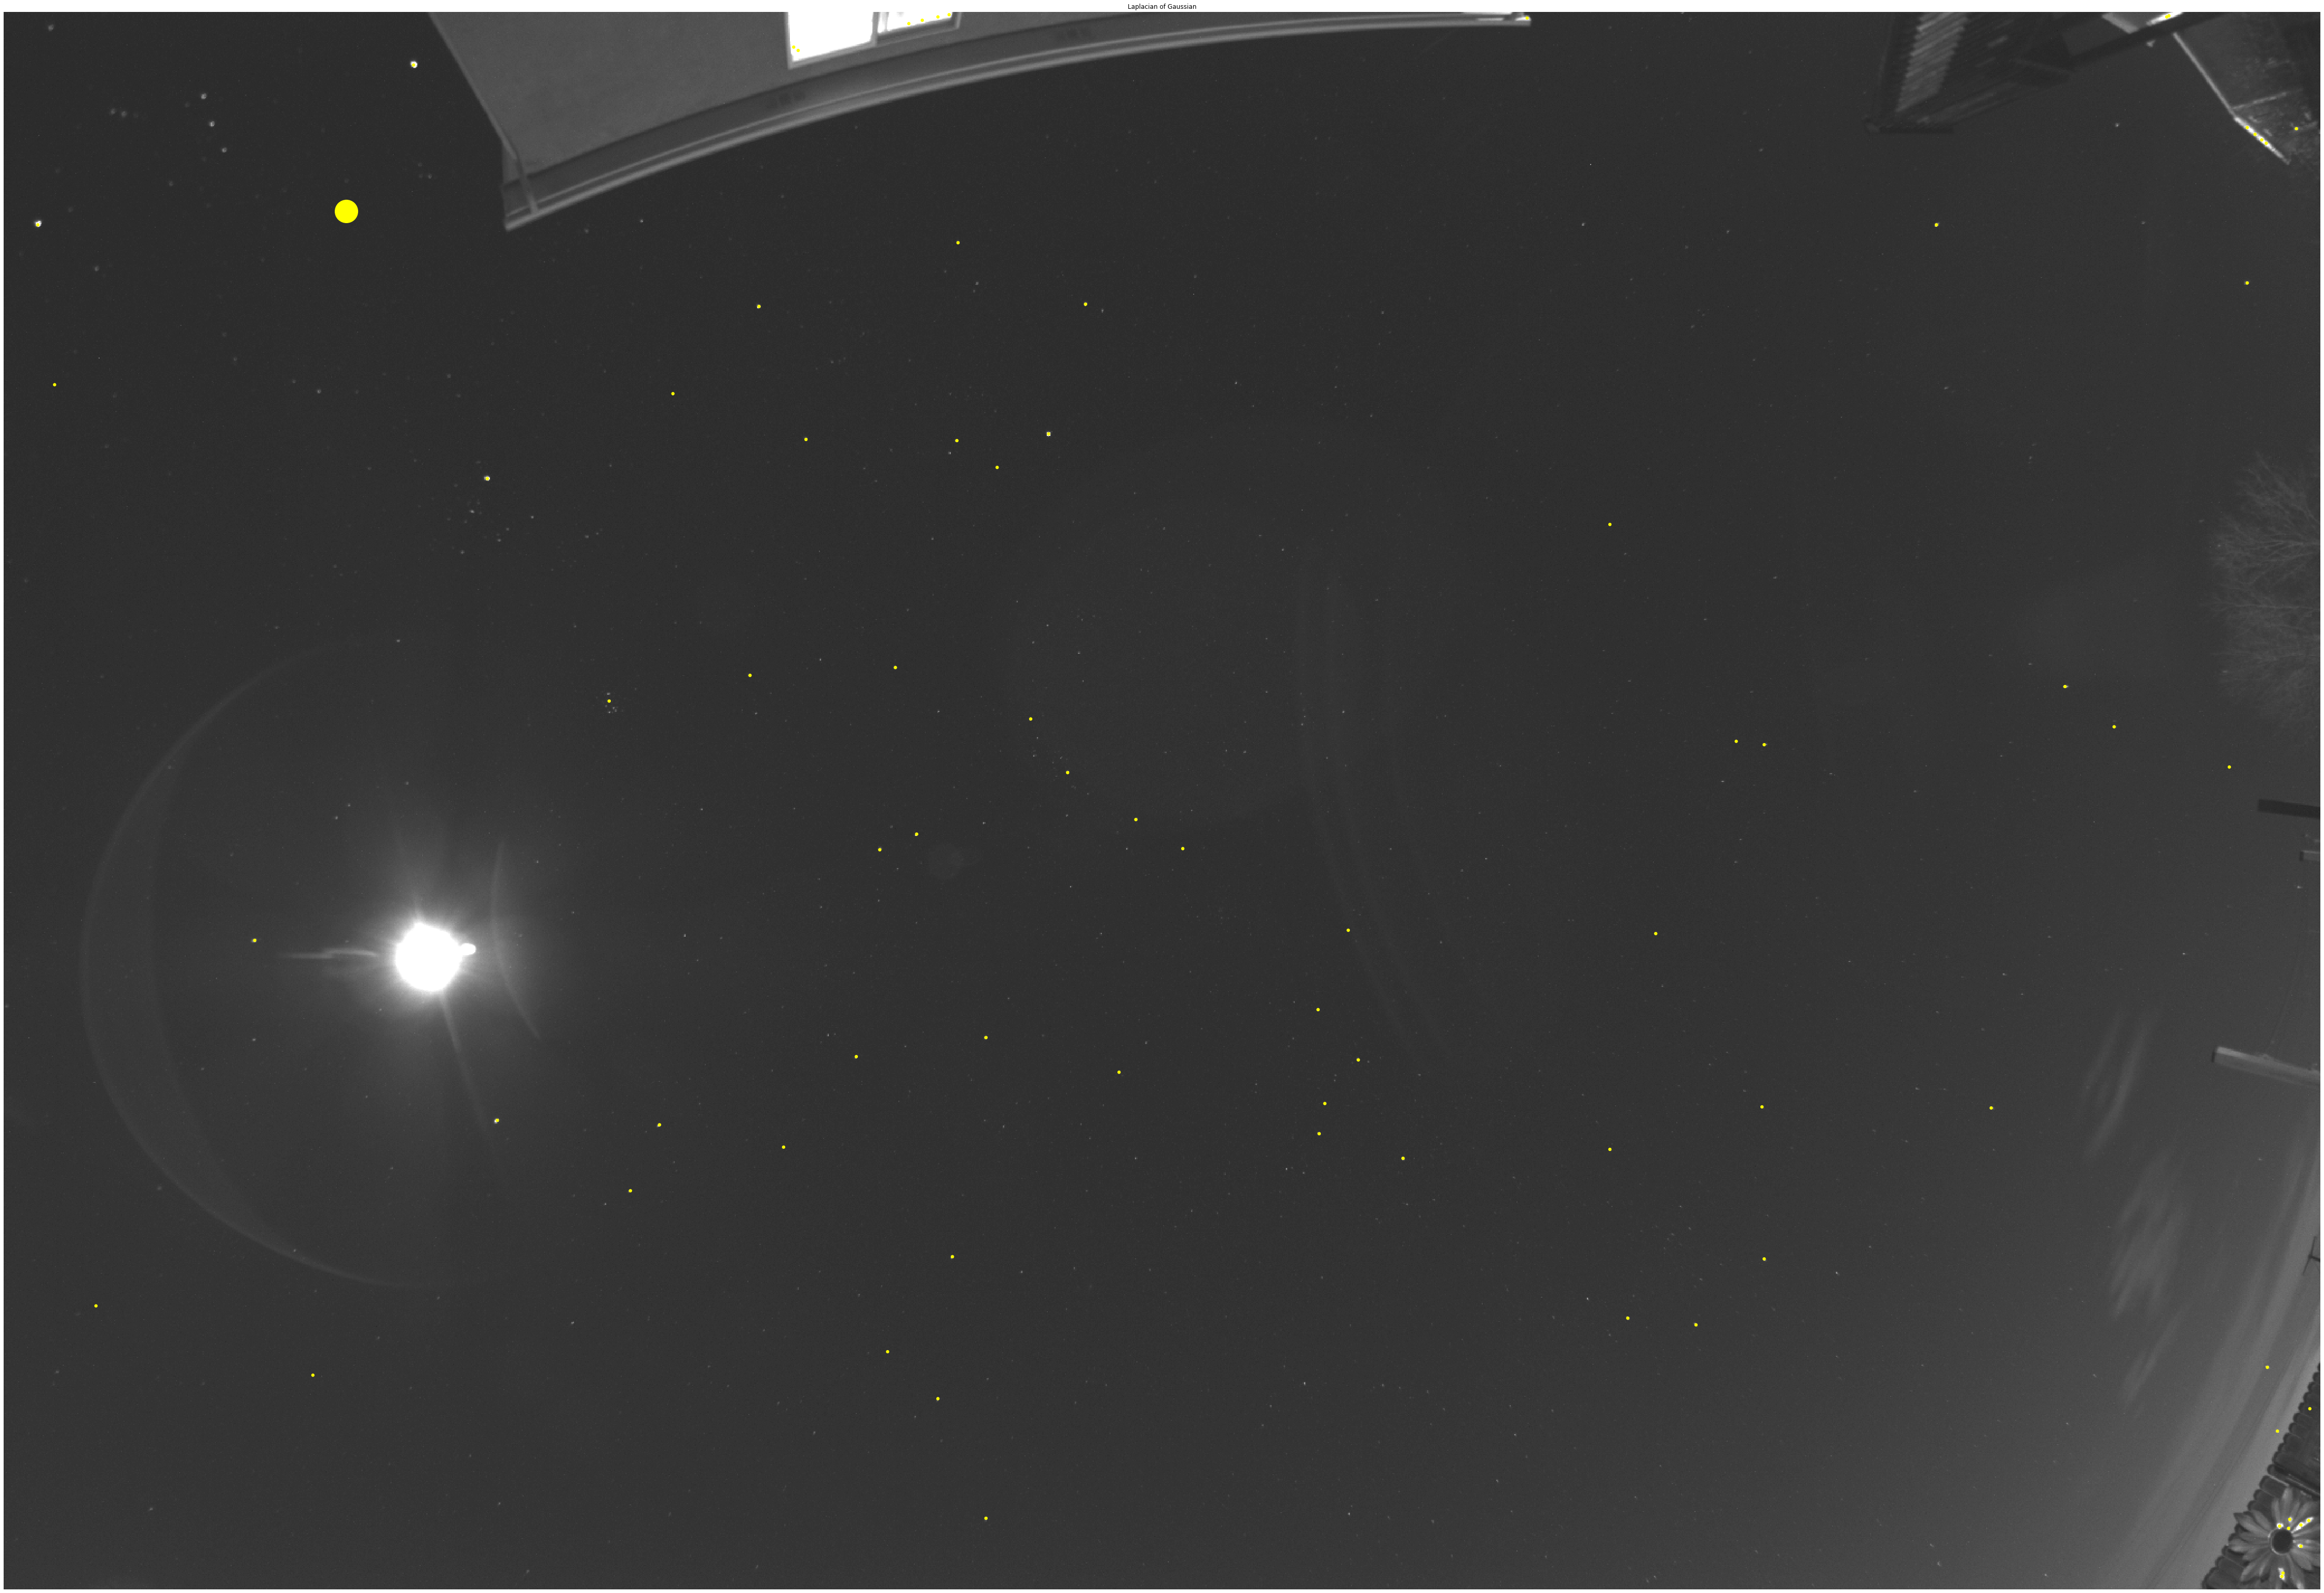

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)
sequence = zip(blobs_list, colors, titles)
for idx, (blobs, color, title) in enumerate(sequence):
    ax.set_title(title)
    ax.imshow(out*swgain, cmap='gray', interpolation='none',vmin=0.1, vmax=0.6)
    for sidx,blob in enumerate(starblobs):
        y, x, r = blob
        if sidx == testidx:
            r *= 10
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=True)
        ax.add_patch(c)
    ax.set_axis_off()
    

plt.show()

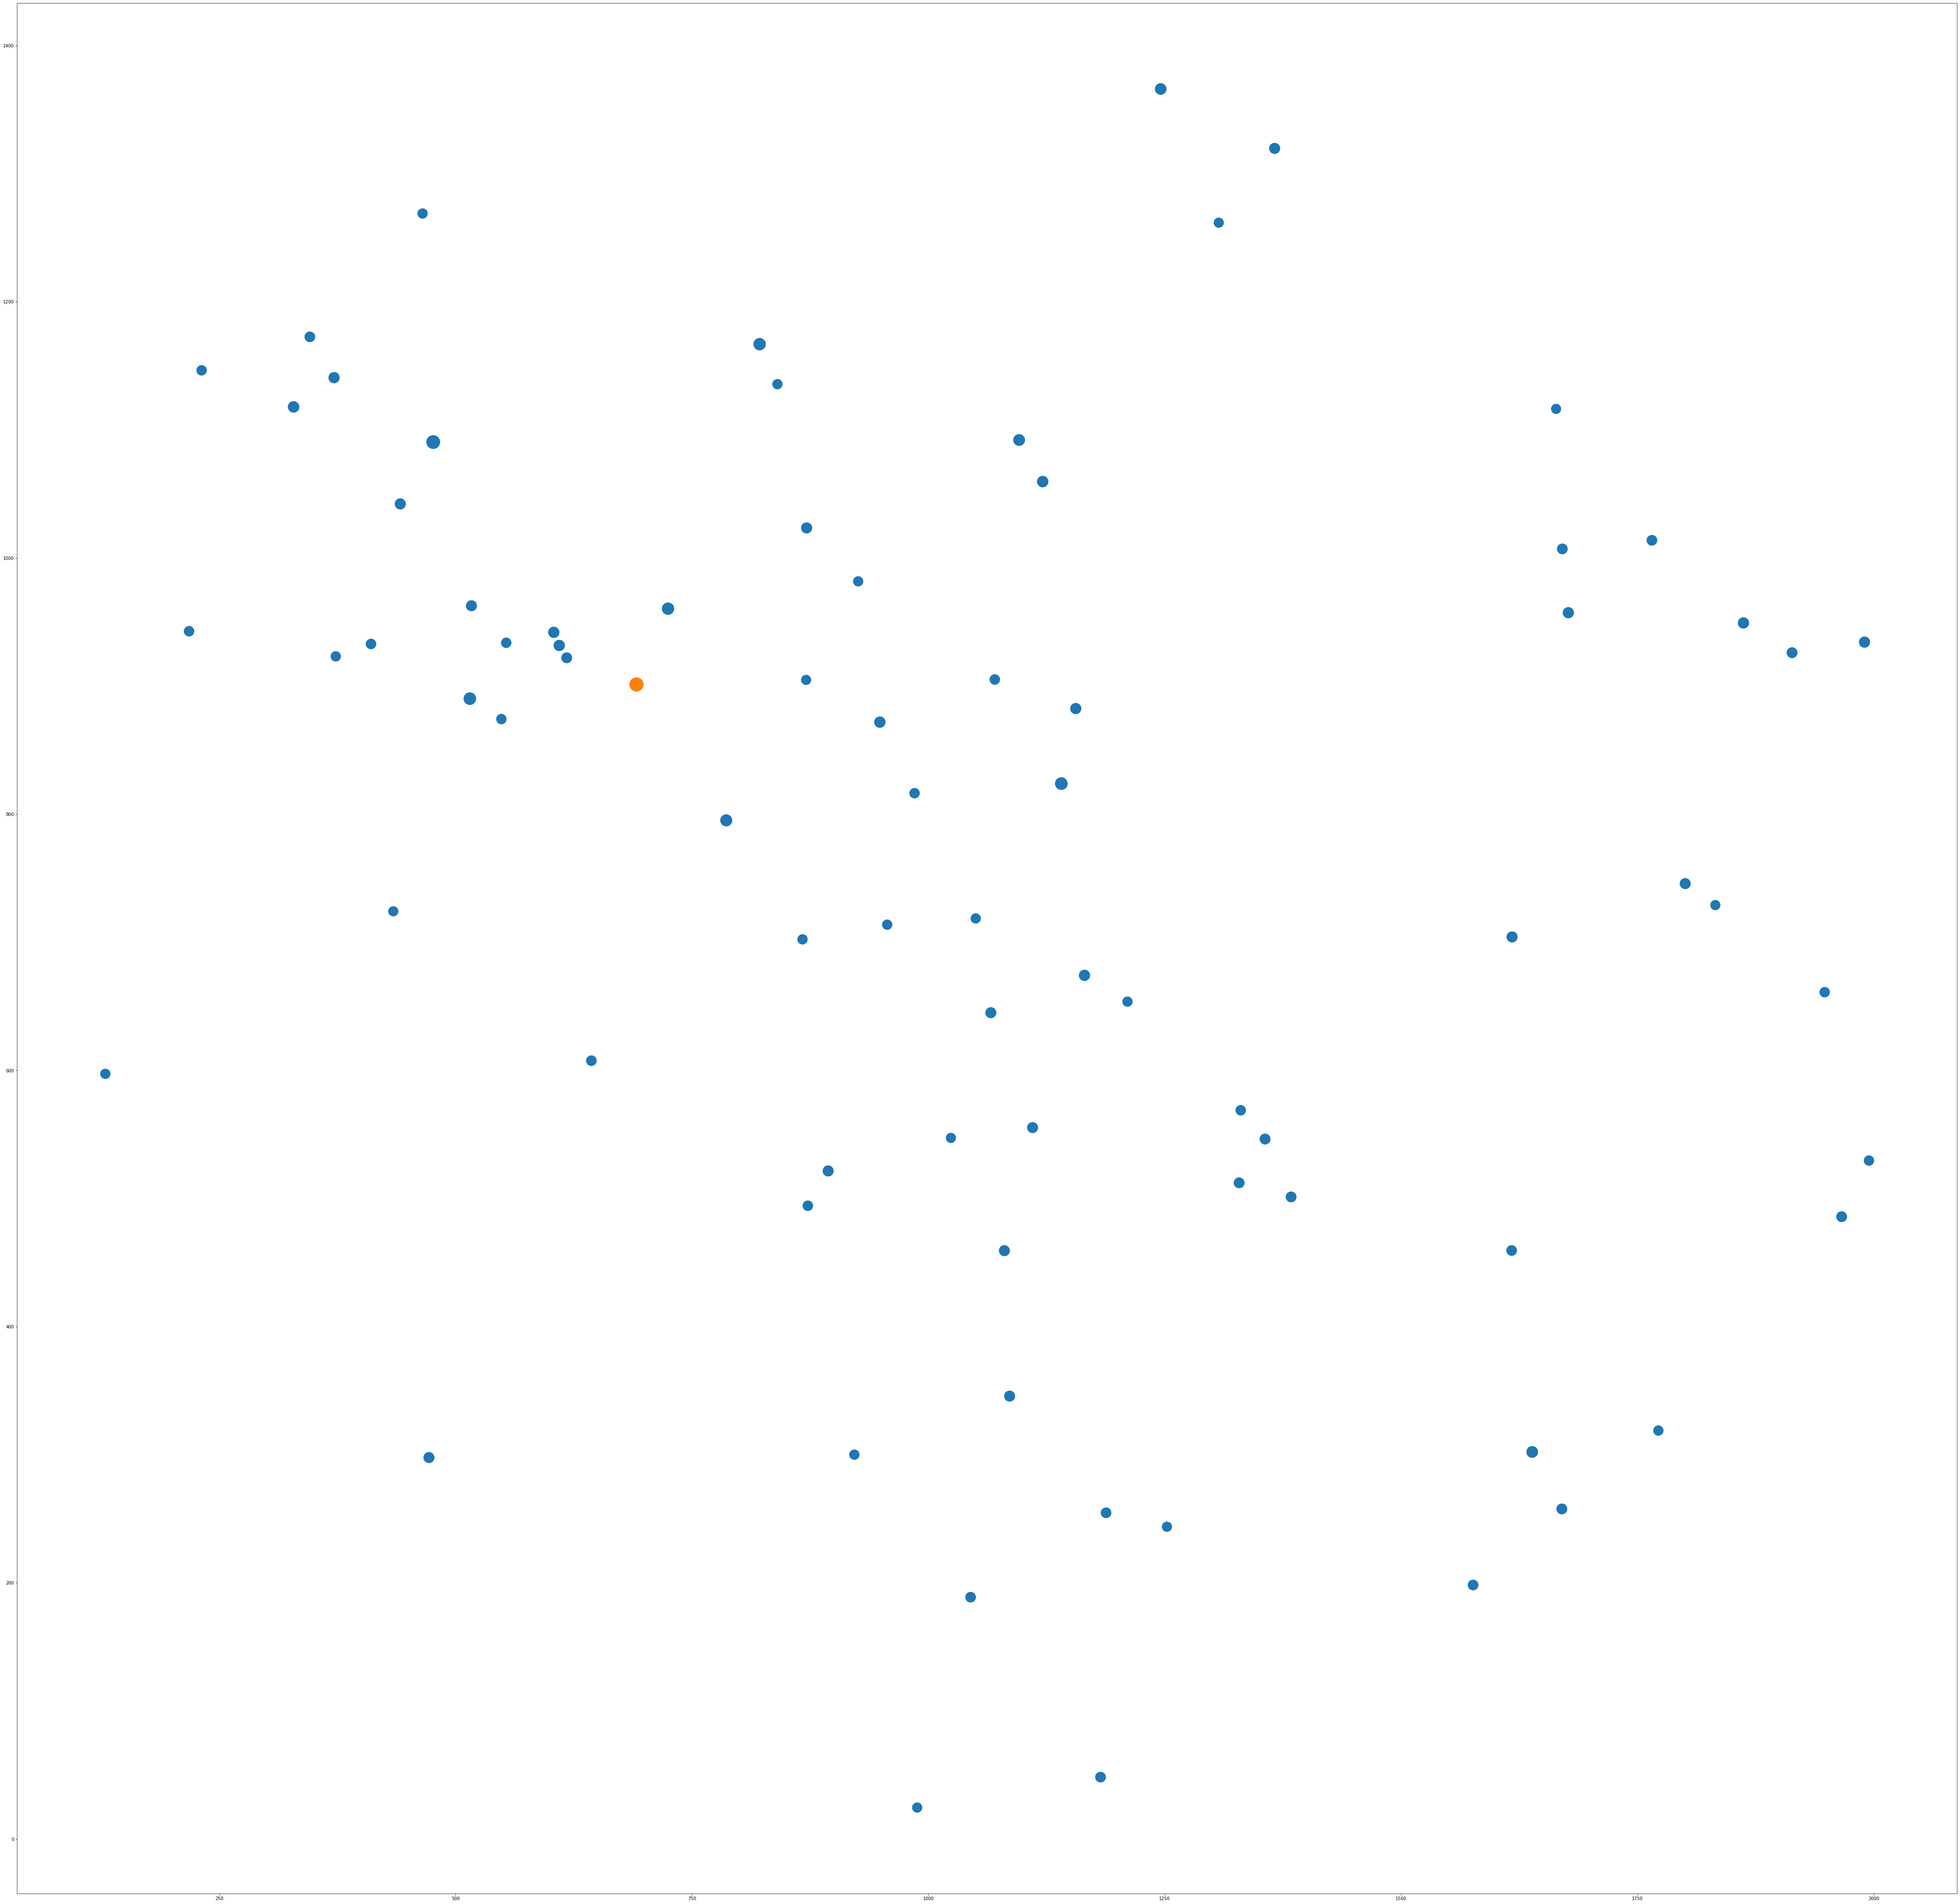

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)

for cnt in range(1):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute+cnt,
               timestamp.second)
#     print(t)
#     astrometric = boston.at(t).observe(bright_stars)
    apparent = cos.at(t).observe(bright_stars).apparent()
#     ra, dec, distance = apparent.radec('date')
    alt,az,distance = apparent.altaz()
    az_deg = np.pi*np.array(az.degrees) / 180
#     ax.scatter(az_deg, 90 - alt.degrees, 50*df['magnitude'], 'k')
    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 90)
    mag = np.array(10*(8-df['magnitude']))[idxs]
    x = (rad[idxs]*np.cos(az_deg[idxs])/180 + 0.5) * 4144/2
    y = (rad[idxs]*np.sin(az_deg[idxs])/180 + 0.5) * 2822/2
    hipvals = hips[idxs]
    ax.scatter(x, y,mag*10)
    ax.scatter(x[foundidx],y[foundidx],1000)
    
plt.show()